In [0]:
#importing all the required libraries for Data Preparation
import io
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
import math
import operator
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler

**Uploading Train data**

In [0]:
#Uploading file to Google Colab
uploaded = files.upload()

Saving trainProdSelection.csv to trainProdSelection (1).csv


In [0]:
#Reading that uploaded file to colab
train_data =  pd.read_csv(io.BytesIO(uploaded['trainProdSelection.csv']))
# Dataset is now stored in a Pandas Dataframe
train_data.head(3)

,id,Type,LifeStyle,Vacation,eCredit,salary,property,label
0,1,student,spend>saving,6,40,13.62,3.2804,C1
1,2,student,spend>saving,11,21,15.32,2.0232,C1
2,3,student,spend>saving,7,64,16.55,3.1202,C1


**Uploading Test data**

In [0]:
#Uploading file to Google Colab
uploaded = files.upload()

Saving testProdSelection.csv to testProdSelection (1).csv


In [0]:
#Reading that uploaded file to colab
test_data = pd.read_csv(io.BytesIO(uploaded['testProdSelection.csv']))
# Dataset is now stored in a Pandas Dataframe
test_data.head(3)

,id,Type,LifeStyle,Vacation,eCredit,salary,property,label
0,1,student,spend<saving,12,19,14.79,3.7697,C1
1,2,student,spend>>saving,29,10,16.19,2.4839,C1
2,3,student,spend<<saving,28,60,15.46,1.1885,C1


## Exploratory Data Analysis (EDA) 

In [0]:
print(train_data.shape)
print(test_data.shape)

(186, 8)
(21, 8)


In [0]:
print(train_data.dtypes)

id             int64
Type          object
LifeStyle     object
Vacation       int64
eCredit        int64
salary       float64
property     float64
label         object
dtype: object


In [0]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 8 columns):
id           186 non-null int64
Type         186 non-null object
LifeStyle    186 non-null object
Vacation     186 non-null int64
eCredit      186 non-null int64
salary       186 non-null float64
property     186 non-null float64
label        186 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 11.7+ KB
None


**Outlier Analysis**

**Box Plot**

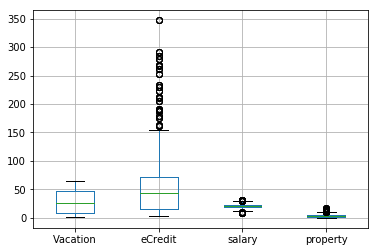

In [0]:
numColumnNames = np.array(train_data.select_dtypes(include=["int64","float"]).columns)
#removing id column while checking for outliers
numColumnNames = numColumnNames[1:]
numData = train_data[numColumnNames]

for col in numColumnNames:
  numData.boxplot(column=list(numColumnNames))

From the above plot it is clear tha outliers are present in features "eCredit,salary and property".So,now we just cape and floor the data.As the dataset is very small it's not good to remove the outliers

### Outlier Capping and Flooring

In [0]:
def outlierCapFloor(data):
       
  numColumnNames = np.array(data.select_dtypes(include=["int64","float"]).columns)
  catColumnNames = np.array(data.select_dtypes(include=["object"]).columns)
  remColumnNames = np.array(data.select_dtypes(exclude=["int64","float","object"]).columns)

  catData = data[catColumnNames]
  numData = data[numColumnNames]
  remData = data[remColumnNames]
  for col in numData.columns:
    if "id" in col.lower(): 
      continue
    else:
      percentiles = numData[col].quantile([0.01,0.99]).values
      numData[col][numData[col] <= percentiles[0]] = percentiles[0]
      numData[col][numData[col] >= percentiles[1]] = percentiles[1]
      
  data = pd.concat([numData,data[catColumnNames],data[remColumnNames]], axis=1)

  return data

train_data = outlierCapFloor(train_data)
train_data.head()

,id,Vacation,eCredit,salary,property,Type,LifeStyle,label
0,1,6.0,40.0,13.62,3.2804,student,spend>saving,C1
1,2,11.0,21.0,15.32,2.0232,student,spend>saving,C1
2,3,7.0,64.0,16.55,3.1202,student,spend>saving,C1
3,4,3.0,47.0,15.71,3.4022,student,spend>saving,C1
4,5,15.0,10.0,16.96,2.2825,student,spend>saving,C1


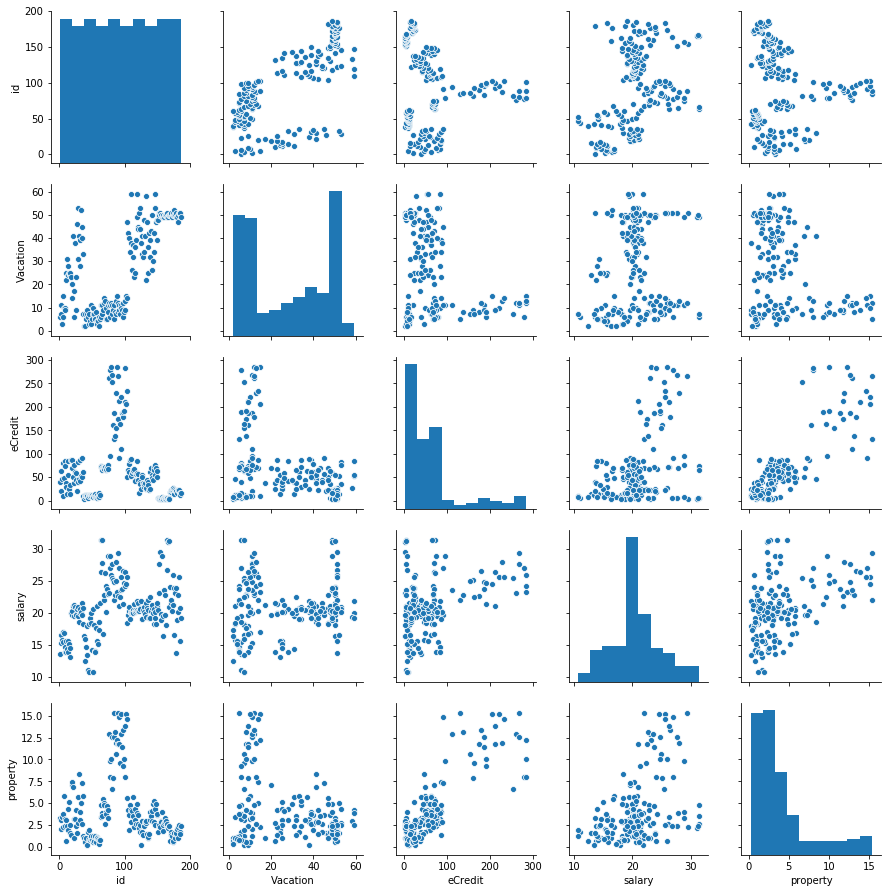

In [0]:
sns.pairplot(train_data)

#### Checking for Duplicates 

In [0]:
def duplicateCheck(data):
  data = data.drop_duplicates(keep = "first")
  return data

print("shape before duplicateCheck -- ",train_data.shape)
train_data = duplicateCheck(train_data)
test_data = duplicateCheck(test_data)
print("shape after duplicateCheck -- ",train_data.shape)

shape before duplicateCheck --  (186, 8)
shape after duplicateCheck --  (186, 8)


#### Missing Value Check

In [0]:
train_data.isnull().sum().sort_values(ascending=False)

label        0
LifeStyle    0
Type         0
property     0
salary       0
eCredit      0
Vacation     0
id           0
dtype: int64

In [0]:
test_data.isnull().sum().sort_values(ascending=False)

label        0
property     0
salary       0
eCredit      0
Vacation     0
LifeStyle    0
Type         0
id           0
dtype: int64

* No missing values in both train and test datasets

#### Encoding Categorical variables

In [0]:
train_encoded = pd.get_dummies(train_data[['Type','LifeStyle']],drop_first=True)
train_encoded.head()

,Type_engineer,Type_librarian,Type_professor,Type_student,LifeStyle_spend<saving,LifeStyle_spend>>saving,LifeStyle_spend>saving
0,0,0,0,1,0,0,1
1,0,0,0,1,0,0,1
2,0,0,0,1,0,0,1
3,0,0,0,1,0,0,1
4,0,0,0,1,0,0,1


In [0]:
test_encoded = pd.get_dummies(test_data[['Type','LifeStyle']],drop_first=True)
test_encoded.head()

,Type_engineer,Type_librarian,Type_professor,Type_student,LifeStyle_spend<saving,LifeStyle_spend>>saving,LifeStyle_spend>saving
0,0,0,0,1,1,0,0
1,0,0,0,1,0,1,0
2,0,0,0,1,0,0,0
3,1,0,0,0,0,0,1
4,0,1,0,0,1,0,0


In [0]:
train_data = train_data.drop(['Type','LifeStyle'],axis=1)
train_data.head()

,id,Vacation,eCredit,salary,property,label
0,1,6.0,40.0,13.62,3.2804,C1
1,2,11.0,21.0,15.32,2.0232,C1
2,3,7.0,64.0,16.55,3.1202,C1
3,4,3.0,47.0,15.71,3.4022,C1
4,5,15.0,10.0,16.96,2.2825,C1


In [0]:
test_data = test_data.drop(['Type','LifeStyle'],axis=1)
test_data.head()

,id,Vacation,eCredit,salary,property,label
0,1,12,19,14.7900,3.7697,C1
1,2,29,10,16.1900,2.4839,C1
2,3,28,60,15.4600,1.1885,C1
3,4,15,41,21.2600,1.4379,C1
4,5,2,9,19.7207,0.6913,C1


In [0]:
train_data_encoded = pd.concat([train_data,train_encoded],axis=1)
train_data_encoded.head()

,id,Vacation,eCredit,salary,property,label,Type_engineer,Type_librarian,Type_professor,Type_student,LifeStyle_spend<saving,LifeStyle_spend>>saving,LifeStyle_spend>saving
0,1,6.0,40.0,13.62,3.2804,C1,0,0,0,1,0,0,1
1,2,11.0,21.0,15.32,2.0232,C1,0,0,0,1,0,0,1
2,3,7.0,64.0,16.55,3.1202,C1,0,0,0,1,0,0,1
3,4,3.0,47.0,15.71,3.4022,C1,0,0,0,1,0,0,1
4,5,15.0,10.0,16.96,2.2825,C1,0,0,0,1,0,0,1


In [0]:
test_data_encoded = pd.concat([test_data,train_encoded],axis=1)
test_data_encoded.head()

,id,Vacation,eCredit,salary,property,label,Type_engineer,Type_librarian,Type_professor,Type_student,LifeStyle_spend<saving,LifeStyle_spend>>saving,LifeStyle_spend>saving
0,1.0,12.0,19.0,14.7900,3.7697,C1,0,0,0,1,0,0,1
1,2.0,29.0,10.0,16.1900,2.4839,C1,0,0,0,1,0,0,1
2,3.0,28.0,60.0,15.4600,1.1885,C1,0,0,0,1,0,0,1
3,4.0,15.0,41.0,21.2600,1.4379,C1,0,0,0,1,0,0,1
4,5.0,2.0,9.0,19.7207,0.6913,C1,0,0,0,1,0,0,1


In [0]:
y_train = train_data_encoded['label']
y_test = test_data_encoded['label']

In [0]:
X_train = train_data_encoded.drop(["id","label"],axis=1)
X_test = test_data_encoded.drop(["id","label"],axis=1)

In [0]:
X_test = X_test[0:21]
y_test = y_test[0:21]

### Scaling Data 

In [0]:
#Scaling a data is always a good idea while using KNN
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))

In [0]:
# Changing the index of the records to sequential
X_train.index=range(len(X_train))
y_train.index=range(len(y_train))
X_test.index=range(len(X_test))
y_test.index=range(len(y_test))

## Model Building

In [0]:
# Function to return the list of distances of the test records from train records
def distNeighbours(X_train,Y_train,X_test,K):
    distance=[]
    for i in range(len(X_train)):
        eDistance=0
        for j in range(len(X_train.columns)):   
                eDistance+=round(np.sqrt(pow((X_train.iloc[i,j]-X_test[j]),2)),2)
        distance.append((eDistance,i,Y_train.iloc[i]))
        distance=sorted(distance, key=lambda x: x[0])[0:K]
    return distance

In [0]:
# Predict the output of the categorical variables based on K nearest neighbours 
# Output is the most frequent class among K nearest neighbours
def predictOutputCategorical(X_train,Y_train,X_test,K):
    neighbours=[]
    responses=[]
    for i in range(len(X_test)):
        neighbours.append(distNeighbours(X_train,Y_train,X_test.iloc[i,:],K))
    for i in neighbours:
        votes={}
        for j in i:
            if j[-1] in votes.keys():
                votes[j[-1]]=votes[j[-1]]+1
            else:
                votes[j[-1]]=1
        responses.append(sorted(votes,key=votes.get,reverse=True)[0])
    return responses

In [0]:
# Predict the output of the numeric variables based on K nearest neighbours
# Output is the mean of the K nearest neighbours
def predictOutputNumeric(X_train,Y_train,X_test,K):
    neighbours=[]
    responses=[]
    for i in range(len(X_test)):
        neighbours.append(distNeighbours(X_train,Y_train,X_test.iloc[i,:],K))
    for i in neighbours:
        mean=0
        for j in i:
            mean+=j[-1]
        mean=mean/K
        responses.append(mean)
    return responses

In [0]:
# Accuarcy of the categorical predictions 
def getAccuracyCategorical(actual,predicted):
    correct=0
    for i in range(len(predicted)):
        if predicted[i]==actual[i]:
            correct+=1
    return round((correct/len(actual))*100,2)
  
# Accuarcy of the numerical predictions
def getAccuracyNumeric(actual,predicted):
    error=0
    for i in range(len(predicted)):
        error+=pow((actual[i]-predicted[i]),2)
    error=error/len(predicted)-1
    return 100-error

In [0]:
acc = []
# Predict Classes
for i in range(1,26):
  output = predictOutputCategorical(X_train,y_train,X_test,i)
  acc_i = getAccuracyCategorical(y_test,output)
  print("for k = ",i," accuracy = ",acc_i)
  acc.append(acc_i)

for k =  1  accuracy =  28.57
for k =  2  accuracy =  28.57
for k =  3  accuracy =  66.67
for k =  4  accuracy =  52.38
for k =  5  accuracy =  76.19
for k =  6  accuracy =  61.9
for k =  7  accuracy =  61.9
for k =  8  accuracy =  52.38
for k =  9  accuracy =  52.38
for k =  10  accuracy =  52.38
for k =  11  accuracy =  52.38
for k =  12  accuracy =  52.38
for k =  13  accuracy =  52.38
for k =  14  accuracy =  57.14
for k =  15  accuracy =  38.1
for k =  16  accuracy =  52.38
for k =  17  accuracy =  47.62
for k =  18  accuracy =  61.9
for k =  19  accuracy =  57.14
for k =  20  accuracy =  52.38
for k =  21  accuracy =  76.19
for k =  22  accuracy =  71.43
for k =  23  accuracy =  66.67
for k =  24  accuracy =  61.9
for k =  25  accuracy =  52.38


### Accuracy vs K-value

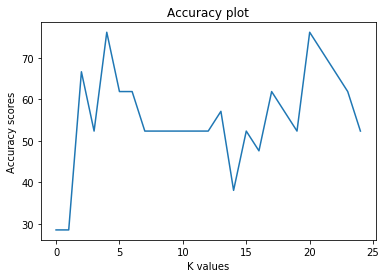

In [0]:
# Generating the y positions.Later, we'll use them to replace them with models.
y_positions = range(25)
# Creating our bar plot
plt.plot(y_positions, acc)
#models on x,y axis
plt.xlabel('K values')
plt.ylabel('Accuracy scores')
#title 
plt.title("Accuracy plot")
plt.show()

* Optimal value of K is 5 with maximum accuracy of 76.19 %
